<a href="https://colab.research.google.com/github/Sudip-8345/Corrective-RAG/blob/main/C-RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install -q langchain langchain-google-genai langchain_community langchain-core langchain-chroma langchain-text-splitters langchain-huggingface langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 3.2 MB/s eta 0:00:00


In [11]:
!pip install -q sentence-transformers

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(len(doc_splits))

730


In [17]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [30]:
import os
GOOGLE_API_KEY="your gemini api key"
GROQ_API_KEY="your groq api key"
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [154]:
### Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    score: float = Field(
        description="Document's relevancy to the question between 0 and 1 "
    )


# LLM with function call
llm = ChatGroq(model="llama-3.1-8b-instant")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a floating score from 0 to 1 by answering only the float score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}).score)
print(len(docs))

0.9
4


In [122]:
### Generate

from langsmith import Client
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

# Prompt
client = Client()
prompt = client.pull_prompt("rlm/rag-prompt")

# LLM
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Long-term memory in a LLM-powered autonomous agent system provides the agent with the capability to retain and recall infinite information over extended periods, often by leveraging an external vector store and fast retrieval. This allows the agent to learn from past experiences and recall information as needed. It is a key component of the agent's memory system.


In [34]:
### Question Re-writer

# LLM
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for web search in one line. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'"Agent memory management or cognitive architectures in artificial intelligence"'

In [42]:
!pip install -q langchain-tavily tavily

  Preparing metadata (setup.py) ... done


In [45]:
os.environ['TAVILY_API_KEY']="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"

In [94]:
### Search
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(
    max_results=5,
    topic="general"
)

In [127]:
from typing import TypedDict, Optional, Annotated, List
from langchain_core.documents import Document

In [137]:
class GraphState(TypedDict):
  question : str
  generation : str
  web_search : str
  documents : List[str]

In [138]:
def retrieve(state: GraphState):
  documents = retriever.invoke(state['question'])
  # docs = [doc.metadata['description'] for doc in documents]
  return {"documents" : documents}

In [139]:
def generate(state: GraphState):

    docs = state["documents"]

    if len(docs) == 0:
        print("⚠️ No documents to generate from")
        return {"generation": "No relevant documents found."}

    formatted_docs = "\n\n".join(
        doc.page_content for doc in docs
    )

    ans = rag_chain.invoke({
        "context": formatted_docs,
        "question": state["question"]
    })

    return {"generation": ans}

In [155]:
def grade_documents(state: GraphState):
    web_search = "no"
    filtered_docs = []
    relv = []
    for doc in state['documents']:
        grade = retrieval_grader.invoke({
            "question": state["question"],
            "document": doc.page_content   # ✅ FIXED
        })
        if grade.score > 0.6:
          filtered_docs.append(doc)
        relv.append(grade.score)
    if any(i>0.70 for i in relv):
      web_search = "yes"

    return {
        "documents": filtered_docs,
        "web_search": web_search
    }

In [156]:
def transform_question(state:GraphState):
  refined_question = question_rewriter.invoke(state['question'])
  return {'question' : refined_question}

In [157]:
def web_search(state:GraphState):
  documents = state['documents']
  docs = web_search_tool.invoke(state['question'])
  results = docs["results"]
  web_res = "\n".join([d["content"] for d in results])
  web_res = Document(web_res)
  documents.append(web_res)
  return {'documents': documents}

In [158]:
def decide_to_generate(state:GraphState):
  if state['web_search'] == 'yes':
    print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
    return 'transform_query'
  else:
    print("---DECISION: GENERATE---")
    return 'generate'

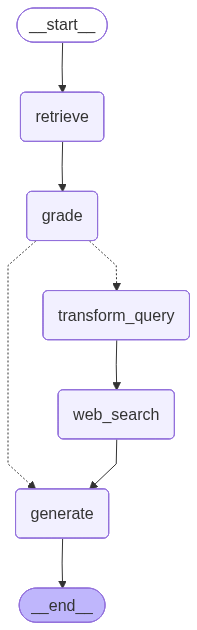

In [159]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(GraphState)
graph.add_node('retrieve', retrieve)
graph.add_node('generate',generate)
graph.add_node('grade',grade_documents)
graph.add_node('web_search', web_search)
graph.add_node('transform_query', transform_question)

graph.add_edge(START, 'retrieve')
graph.add_edge('retrieve', 'grade')
graph.add_conditional_edges(
    'grade',
    decide_to_generate,
     {
        "transform_query": "transform_query",
        'generate' : 'generate'
    }
)
graph.add_edge('transform_query', 'web_search')
graph.add_edge('web_search', 'generate')
graph.add_edge('generate', END)

workflow = graph.compile()
workflow

In [160]:
# Run
inputs = {"question": "agent memory?"}
final_state = workflow.invoke(inputs)
print('Final State : ')
print(final_state)

---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Final State : 
{'question': '"Agent memory capabilities or limitations"', 'generation': 'Agent memory capabilities or limitations refer to the ability of an agent to retain and recall relevant information across time, tasks, and multiple user interactions. Long-term memory, in particular, allows agents to learn from past interactions and adapt over time, but its design and implementation can be challenging, especially at enterprise scale. The limitations of stateless agents with small context windows can be addressed by introducing durable, structured data layers like Agentic Memory.', 'web_search': 'yes', 'documents': [Document(metadata={'language': 'en', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring exampl

In [161]:
# Run
inputs = {"question": "agent memory?"}
for ans in workflow.stream(inputs):
  for key, value in ans.items():
    print(f"Node '{key}':")
  print("\n---\n")
print('Final Answer : ')
print(ans)

Node 'retrieve':

---

---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade':

---

Node 'transform_query':

---

Node 'web_search':

---

Node 'generate':

---

Final Answer : 
{'generate': {'generation': 'Agent memory capabilities or limitations refer to the ability of an agent to retain and recall relevant information across time, tasks, and multiple user interactions. Long-term memory, in particular, allows agents to learn from past interactions and adapt over time, but its design and implementation can be challenging, especially at enterprise scale. The limitations of stateless agents with small context windows can be addressed by introducing durable, structured data layers like Agentic Memory.'}}


In [162]:
# Run
inputs = {"question": "what is ensemble learning"}
for ans in workflow.stream(inputs):
  for key, value in ans.items():
    print(f"Node '{key}':")
  print("\n---\n")
print('Final Answer : ')
print(ans)

Node 'retrieve':

---

---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade':

---

Node 'transform_query':

---

Node 'web_search':

---

Node 'generate':

---

Final Answer : 
{'generate': {'generation': 'Ensemble learning is a machine learning paradigm that combines multiple models to create a more accurate and robust output than any single model. It involves combining predictions from various models, each possibly trained using different algorithms and datasets, to improve predictive performance. Ensemble learning techniques, such as bagging and boosting, are used in applications like renewable energy and medical data analysis to enhance predictive accuracy and resilience against data uncertainties.'}}
